# Phase 1 Project Technical Notebook
Authors: Victor Chen and Kevin McDonough 



In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

## Rotten Tomatoes Data - Business Recommendation 1: High Critic Ratings Doesn't Necessarilly Translate to Box Office Success 

### Importing Rotten Tomatoes Files 

In [2]:
df_rt1 = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
df_rt2 = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='iso8859_1')

In [3]:
df_rt1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [4]:
df_rt2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


The two rotten tomatoes datasets share a common attribute: 'id", so we can merge them using this column

### Data Cleaning:

In [5]:
# Merges the two Rotten Tomatoes dataframes on their shared column: 'id'
df_rt = df_rt1.merge(df_rt2, how='inner', on='id')

In [6]:
import string
df_rt['box_office'] = df_rt['box_office'].str.replace('[{}]'.format(string.punctuation), '')
# Removes the commas from the box office column

In [7]:
df_rt['box_office'] = df_rt['box_office'].apply(lambda x: float(x))
# Changes the box office column from strings to floats

In [8]:
df_rt['runtime'] = df_rt['runtime'].str.strip('minutes')
# Strips the 'minutes' from the runtime column so that we can convert to an int 

In [9]:
df_rt['theater_date'] = pd.to_datetime(df_rt['theater_date'], )
# Changes release date from string to datetime 

In [10]:
df_rt.dropna(subset=['rating_y'], inplace=True)
# drops null values in the rating column

In [11]:
df_rt['rating_y'][0:20]

0       3/5
6         C
7       2/5
11       B-
12      2/4
13        B
14      3/4
15      3/5
16      4/5
17        B
18      2/4
19      4/4
20     6/10
21      1/4
22        8
23      2/5
24    2.5/4
25     4/10
27    2.5/4
29    2.0/5
Name: rating_y, dtype: object

Based on the output above, the rating column is a mess. Some of the ratings are out of 5, some are out of 10, some are our of 4 and some are letter grades. If we want to use this column, we need to figure out a way to standardize it. 

In [12]:
def standardize(rating):
    if rating.endswith('5') and '/' in rating and '.' in rating:
        return (float(rating[0:3]) / float(rating[-1])) * 100
    elif rating.endswith('10') and '/' in rating and '.' in rating:
        return (float(rating[0:3]) / float(rating[-2:])) * 100
    elif rating.endswith('5') and '/' in rating:
        return (float(rating[0]) / float(rating[-1])) * 100
    elif rating.endswith('10') and '/' in rating and len(rating) < 5:
        return (float(rating[0]) / float(rating[-2:])) * 100
    elif rating.endswith('10') and '/' in rating and len(rating) == 5:
        return (float(rating[0:2]) / float(rating[-2:])) * 100
    elif rating.endswith('4') and '/' in rating and '.' in rating:
        return (float(rating[0:3]) / float(rating[-1])) * 100
    elif rating.endswith('5') and '/' in rating:
        return (float(rating[0]) / float(rating[-1])) * 100
    elif rating == 'A+':
        return 98
    elif rating == 'A':
        return 95
    elif rating == 'A-':
        return 92
    elif rating == 'B+':
        return 88
    elif rating == 'B':
        return 85
    elif rating == 'B-':
        return 82
    elif rating == 'C+':
        return 78
    elif rating == 'C':
        return 75
    elif rating == 'C-':
        return 72
    elif rating == 'D+': 
        return 68
    elif rating == 'D':
        return 65
    elif rating == 'D-':
        return 62

In [13]:
standardize('10.0/10')

100.0

The function above takes in a rating and returns an integer from 0 to 100. Because the majority of data points in the 'ratings_y' column are either out of 5, 10, or in letter grade format this function will give us standardized ratings for a majority of the entries. 

In [14]:
ratings = list(df_rt['rating_y'].value_counts().index[0:])
len(ratings)
# creates a list of all unique ratings so that we can test our function

186

In [15]:
standardized_list = []
for rating in ratings:
    new_rating = standardize(rating)
    standardized_list.append(new_rating)
    
none_count = []
for item in standardized_list:
    if item == None:
        none_count.append(item)

1 - (len(none_count)) / len(ratings)

0.5913978494623655

The above tells us that our function was able to capture ~60% of the unique review types. Although 60% doesn't sound great, the majority of reviews are in the common formats featured above so we won't lose too much data when we implement the function

In [16]:
df_rt['rating_y'] = df_rt['rating_y'].apply(standardize)

In [17]:
df_rt.dropna(subset=['rating_y'], inplace=True)

In [18]:
df_rt

,id,synopsis,rating_x,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,review,rating_y,fresh,critic,top_critic,publisher,date
0,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,"Jan 1, 2013",$,600000.0,108,Entertainment One,A distinctly gallows take on contemporary fina...,60.0,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
6,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,"Jan 1, 2013",$,600000.0,108,Entertainment One,"Quickly grows repetitive and tiresome, meander...",75.0,rotten,Eric D. Snider,0,EricDSnider.com,"July 17, 2013"
7,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,"Jan 1, 2013",$,600000.0,108,Entertainment One,Cronenberg is not a director to be daunted by ...,40.0,rotten,Matt Kelemen,0,Las Vegas CityLife,"April 21, 2013"
11,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,"Jan 1, 2013",$,600000.0,108,Entertainment One,"While not one of Cronenberg's stronger films, ...",82.0,fresh,Emanuel Levy,0,EmanuelLevy.Com,"February 3, 2013"
13,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,"Jan 1, 2013",$,600000.0,108,Entertainment One,The anger over the injustice of the financial ...,85.0,fresh,Robert Roten,0,Laramie Movie Scope,"January 7, 2013"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54424,2000,"Suspended from the force, Paris cop Hubert is ...",R,Action and Adventure|Art House and Internation...,NaN,Luc Besson,2001-09-27,"Feb 11, 2003",NaN,NaN,94,Columbia Pictures,Dawdles and drags when it should pop; it doesn...,30.0,rotten,Manohla Dargis,1,Los Angeles Times,"September 26, 2002"
54428,2000,"Suspended from the force, Paris cop Hubert is ...",R,Action and Adventure|Art House and Internation...,NaN,Luc Besson,2001-09-27,"Feb 11, 2003",NaN,NaN,94,Columbia Pictures,NaN,20.0,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,"Suspended from the force, Paris cop Hubert is ...",R,Action and Adventure|Art House and Internation...,NaN,Luc Besson,2001-09-27,"Feb 11, 2003",NaN,NaN,94,Columbia Pictures,NaN,40.0,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,"Suspended from the force, Paris cop Hubert is ...",R,Action and Adventure|Art House and Internation...,NaN,Luc Besson,2001-09-27,"Feb 11, 2003",NaN,NaN,94,Columbia Pictures,NaN,50.0,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"


Rotten tomatoes uses a "Tomatometer" to rate movies. If a critic likes the movie, they designate "fresh," if they don't enjoy it they desginate it "rotten" The tomatometer represents the percentage of fresh designations. Using the fresh column from the dataset, we can create a tomatometer for each movie. 

In [19]:
def fresh(rating):
    if rating == 'fresh':
        return 1
    elif rating == 'rotten':
        return 0 

This function returns a rating of 1 if the review is fresh and 0 if it is rotten. We can then use this to come up with  tomatometer for each movie - it will be the mean of all rotten/fresh values for a speficied movie 

In [20]:
df_rt['fresh'] = df_rt['fresh'].apply(fresh)
# applies the function to the fresh column

In [21]:
df_rt['currency'].value_counts()
# This shows us that all of the currency is in dollars so we don't have to worry about different units 

$    19471
Name: currency, dtype: int64

In [22]:
df_rt['rating_y'] = df_rt.groupby('id')['rating_y'].transform(
    lambda grp: np.mean(grp)
)
df_rt['fresh'] = df_rt.groupby('id')['fresh'].transform(
    lambda grp: np.mean(grp)
)

In [23]:
df_rt

,id,synopsis,rating_x,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,review,rating_y,fresh,critic,top_critic,publisher,date
0,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,"Jan 1, 2013",$,600000.0,108,Entertainment One,A distinctly gallows take on contemporary fina...,65.938889,0.688889,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
6,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,"Jan 1, 2013",$,600000.0,108,Entertainment One,"Quickly grows repetitive and tiresome, meander...",65.938889,0.688889,Eric D. Snider,0,EricDSnider.com,"July 17, 2013"
7,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,"Jan 1, 2013",$,600000.0,108,Entertainment One,Cronenberg is not a director to be daunted by ...,65.938889,0.688889,Matt Kelemen,0,Las Vegas CityLife,"April 21, 2013"
11,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,"Jan 1, 2013",$,600000.0,108,Entertainment One,"While not one of Cronenberg's stronger films, ...",65.938889,0.688889,Emanuel Levy,0,EmanuelLevy.Com,"February 3, 2013"
13,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,"Jan 1, 2013",$,600000.0,108,Entertainment One,The anger over the injustice of the financial ...,65.938889,0.688889,Robert Roten,0,Laramie Movie Scope,"January 7, 2013"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54424,2000,"Suspended from the force, Paris cop Hubert is ...",R,Action and Adventure|Art House and Internation...,NaN,Luc Besson,2001-09-27,"Feb 11, 2003",NaN,NaN,94,Columbia Pictures,Dawdles and drags when it should pop; it doesn...,59.520833,0.458333,Manohla Dargis,1,Los Angeles Times,"September 26, 2002"
54428,2000,"Suspended from the force, Paris cop Hubert is ...",R,Action and Adventure|Art House and Internation...,NaN,Luc Besson,2001-09-27,"Feb 11, 2003",NaN,NaN,94,Columbia Pictures,NaN,59.520833,0.458333,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,"Suspended from the force, Paris cop Hubert is ...",R,Action and Adventure|Art House and Internation...,NaN,Luc Besson,2001-09-27,"Feb 11, 2003",NaN,NaN,94,Columbia Pictures,NaN,59.520833,0.458333,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,"Suspended from the force, Paris cop Hubert is ...",R,Action and Adventure|Art House and Internation...,NaN,Luc Besson,2001-09-27,"Feb 11, 2003",NaN,NaN,94,Columbia Pictures,NaN,59.520833,0.458333,Christopher Null,0,Filmcritic.com,"September 7, 2003"


The above code first groups the data by indivual movie ('using the 'id' column) and then replaces the individual 'rating' the mean rating for that movie. The same process is repeated for the fresh column. Looking at the df above, we can now see that all values in the "fresh" and "rating" columns are the same for each individual movie (movies with the same value in the 'id' column) 

In [24]:
df_rt = df_rt.drop_duplicates(subset='id')
# This code drops duplicates in the 'id' column so now we only have one row for each movie 

Ideally, if the standardized rating function worked well, the 'fresh' column and 'rating_y' column will be correlated -- let's double check:

In [25]:
np.corrcoef(df_rt['rating_y'], df_rt['fresh'])[1][0]

0.8238504128100251

That's a pretty strong correlation! 

# Business Understanding

Let's use our two rating columns to see if there is any correlation between positive ratings and high box office earnings 

In [26]:
df_rt = df_rt.dropna(subset=['box_office'])
df_rt['box_office'] = df_rt['box_office'].apply(lambda x: x/1000000)
# Drops NA values in the box office column and then converts from dollars to $mm so it is easier to digest

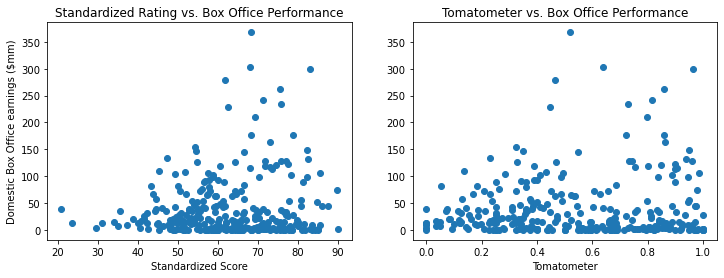

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
x1 = df_rt['rating_y']
x2 = df_rt['fresh']
y = df_rt['box_office']
ax1.scatter(x1,y);
ax2.scatter(x2,y);

ax1.set_title('Standardized Rating vs. Box Office Performance');
ax1.set_xlabel('Standardized Score');
ax1.set_ylabel('Domestic Box Office earnings ($mm)');

ax2.set_title('Tomatometer vs. Box Office Performance');
ax2.set_xlabel('Tomatometer');
ax1.set_ylabel('Domestic Box Office earnings ($mm)');
plt.savefig('Visualizations/RT_ratings_box_correlation.PNG')

It doesn't look like there is necessarily a strong relationship between ratings and box office performance but let's double check the correlation to be sure:

In [28]:
rating_correlation = round(np.corrcoef(df_rt['rating_y'], df_rt['box_office'])[1][0],3)
tomatometer_correlation = round(np.corrcoef(df_rt['fresh'], df_rt['box_office'])[1][0],3)

print("The correlation between standardized rating and box office revenue is {}".format(rating_correlation))
print("The correlation between tomatometer and box office revenue is {}".format(tomatometer_correlation))

The correlation between standardized rating and box office revenue is 0.102
The correlation between tomatometer and box office revenue is 0.066


Based on this analysis we did not find a correlation between critic ratings and box office success. Therefore, for future analysis, we will put less focus on critic reception, and instead focus on other attributes that might lead to profitability. Additionally, for future analysis we will focus on datasets that contain box office revenue information to guide our insights. As a result, we did not focus on several IMDB datasets within the zipped file folder because they only contained ratings information

## IMDB Data - Business Recommendation 2: Identifying Genres, Directors, Actors and Plot Themes that Translate to Higher Gross Revenue

In [29]:
df_imdb = pd.read_csv('zippedData/movie_metadata.csv')
# Imports IMDB Data

In [30]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

In [31]:
df_imdb['gross'] = df_imdb['gross'].apply(lambda x: x/1000000)

The gross revenue column ('gross')  is not very digestible because it is in dollars, the code above turns it into millions 

In [32]:
def split_genres(genre):
    return genre.split('|')[0]

df_imdb['genres'] = df_imdb['genres'].apply(split_genres)

In the IMDB dataset the 'genres' column has multiple entries separated by "|". For example, the first entry is 'Action|Adventure|Fantasy|Sci-Fi'. The above cell creates a function that returns the first main genre listed (so for the first entry it would return "Action"

In [33]:
df_imdb['genres'].value_counts()

Comedy         1329
Action         1153
Drama           972
Adventure       453
Crime           349
Biography       252
Horror          232
Documentary      84
Animation        61
Fantasy          53
Mystery          33
Thriller         22
Sci-Fi           13
Western          12
Family           11
Romance           6
Musical           4
Music             1
Film-Noir         1
Game-Show         1
History           1
Name: genres, dtype: int64

# Business Understanding

In [34]:
df_imdb.groupby('genres')['gross'].mean().sort_values(ascending=False)

genres
Family         149.160478
Adventure       86.325758
Animation       85.314064
Action          76.289889
Musical         61.566602
Mystery         48.822296
Fantasy         37.782735
Comedy          35.524880
Biography       35.045008
Horror          34.828279
Crime           29.989961
Drama           28.151436
Sci-Fi          26.071841
Romance         20.886339
Western         11.993216
Documentary     10.802871
Music            3.419967
Thriller         0.540970
Film-Noir             NaN
Game-Show             NaN
History               NaN
Name: gross, dtype: float64

The above cell shows the mean gross revenue for movies in each genre and sorts them from highest to lowest. There is a bit of a drop off after "Musical," so we will use the top 5 genres as a subset moving forward. It is our recommendation that Microsoft should create a movie in one of these genres -- below we will try to make some recommendations of director, actor, and movie plot! 

/Users/kevinmcdonough/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


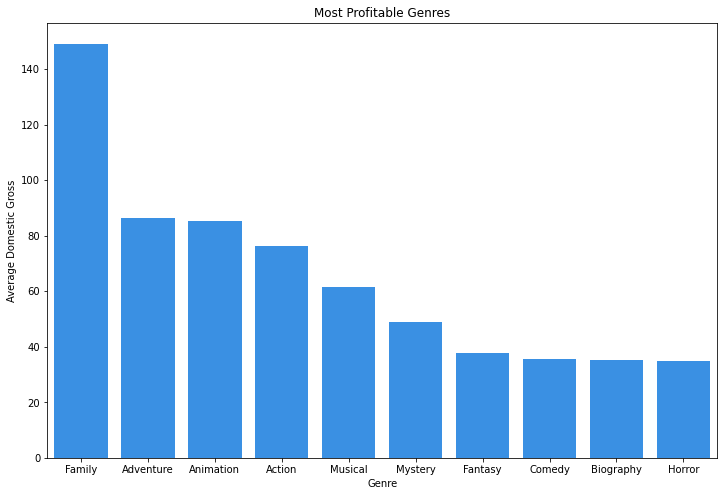

In [35]:
x = list(df_imdb.groupby('genres')['gross'].mean().sort_values(ascending=False).index[0:10])
y= list(df_imdb.groupby('genres')['gross'].mean().sort_values(ascending=False).values[0:10])

fig, ax = plt.subplots(figsize=[12,8])
ax = sns.barplot(x,y,color = "dodgerblue")
ax.set_xlabel('Genre')
ax.set_ylabel('Average Domestic Gross')
ax.set_title('Most Profitable Genres');
plt.savefig('Visualizations/Genre_profitability.png')

In [36]:
df_genre_sub = df_imdb[df_imdb['genres'].isin(['Family', 'Action', 'Adventure', 'Animation', 'Musical'])]
# Creates a new DF that only contains movies in the specified genres

In [37]:
df_genre_sub['director_name'].value_counts()[0:100]

Steven Spielberg    16
Michael Bay         12
Tony Scott          12
Renny Harlin        11
Ridley Scott        11
                    ..
Doug Liman           4
Joss Whedon          4
Hayao Miyazaki       4
Andrew Adamson       4
Joe Wright           4
Name: director_name, Length: 100, dtype: int64

The code above shows the 100 directors who have made the most movies in the genres we have specified. 100 is a bit of an arbitrary cutoff but we wanted to select directors that had experience. Even the 100th person on this list (Luc Besson) has created 4 movies in the specified genres

In [38]:
top_100_directors_for_genre = list(df_genre_sub['director_name'].value_counts().index[0:100])
# Creates a list containing names of the 100 directors who have made the most movies in the specified genre

In [39]:
df_director_sub = df_genre_sub[df_genre_sub['director_name'].isin(top_100_directors_for_genre)]
# Uses the list above to create a new dataframe with only entries for the above directors 

In [40]:
df_director_sub.groupby('director_name').mean()['gross'].sort_values(ascending=False)

director_name
Joss Whedon          432.721657
George Lucas         406.604620
Christopher Nolan    333.470153
Andrew Adamson       284.361730
Peter Jackson        277.994940
                        ...    
John Carpenter        18.085589
Simon Wincer          17.934710
Mark L. Lester         8.687779
Hayao Miyazaki         8.035079
Uwe Boll               3.042558
Name: gross, Length: 100, dtype: float64

The code above groups the directors and shows the average gross revenue for movies they've produced. Based on the output, we should target Joss Whedon, George Lucas, Christopher Nolan, Andrew Agamson and Peter Jackson because they direct profitable movies 

/Users/kevinmcdonough/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


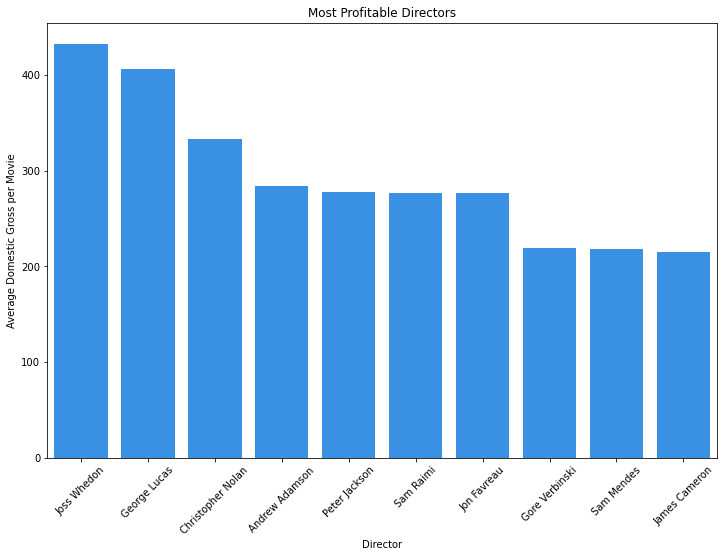

In [41]:
x = df_director_sub.groupby('director_name').mean()['gross'].sort_values(ascending=False).index[0:10]
y = df_director_sub.groupby('director_name').mean()['gross'].sort_values(ascending=False).values[0:10]

fig, ax = plt.subplots(figsize=[12,8])
ax = sns.barplot(x,y, color='dodgerblue')
ax.set_xlabel('Director')
ax.set_ylabel('Average Domestic Gross per Movie')
ax.set_title('Most Profitable Directors');
ax.set_xticklabels(labels=x, rotation=45);
plt.savefig('Visualizations/Director_profitability.png')

# Data Understanding 

In [42]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

Based on the output above, we can see that there are 3 seperate columns for actors

In [43]:
df_2 = df_imdb.copy()
df_3 = df_imdb.copy()

# Creates two copies of the DF

In [44]:
df_imdb.drop(columns=['actor_2_name', 'actor_3_name'], inplace=True)
df_imdb.rename(index=str, columns={"actor_1_name": "actor"}, inplace=True)
# Deletes the actor_2 column and actor_3 column from the original DF and renames the actor_1 column 

In [45]:
df_2.drop(columns=['actor_1_name', 'actor_3_name'], inplace=True)
df_2.rename(index=str, columns={"actor_2_name": "actor"}, inplace=True)
# Deletes the actor_1 column and actor_3 column from the original DF and renames the actor_2 column 

In [46]:
df_3.drop(columns=['actor_1_name', 'actor_2_name'], inplace=True)
df_3.rename(index=str, columns={"actor_3_name": "actor"}, inplace=True)
# Deletes the actor_1 column and actor_3 column from the original DF and renames the actor_2 column 

In [47]:
actors = pd.concat([df_imdb,df_2, df_3])

In [48]:
actors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15129 entries, 0 to 5042
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      15072 non-null  object 
 1   director_name              14817 non-null  object 
 2   num_critic_for_reviews     14979 non-null  float64
 3   duration                   15084 non-null  float64
 4   director_facebook_likes    14817 non-null  float64
 5   actor_3_facebook_likes     15060 non-null  float64
 6   actor_1_facebook_likes     15108 non-null  float64
 7   gross                      12477 non-null  float64
 8   genres                     15129 non-null  object 
 9   actor                      15086 non-null  object 
 10  movie_title                15129 non-null  object 
 11  num_voted_users            15129 non-null  int64  
 12  cast_total_facebook_likes  15129 non-null  int64  
 13  facenumber_in_poster       15090 non-null  float64
 

In [49]:
assert actors['gross'][5043] == actors['gross'][0]

In [50]:
assert actors['actor'][5043] == actors['actor'][0]

AssertionError: 

The above code was a little clunky but we now have a dataframe with all of the actors in one column. We combined 3 indivdual dataframes. The second dataframe contained actors that were previously in the actor_2 column while the 3rd dataframe contained actors that were previously in the actor_3 column. Each of these dataframes was 5,043 rows and each row represents a movie. In the concatanated dataframe, each movie has 3 row entries, one for each actor. The assert statement above shows us that the gross revenue for row 0 is the same as the gross revenue for row 5043 (because they are the same movie!). There is an error in the second assert statement because now they have seperate actors in the actor column

# Business Understanding

In [51]:
actors_genres_sub = actors[actors['genres'].isin(['Family', 'Action', 'Adventure', 'Animation', 'Musical'])]
# This code creates a new DF with only movies in the genres we highlighted before 

In [52]:
actors_genres_sub['actor'].value_counts()[0:200]

Bruce Willis          27
Liam Neeson           21
Sylvester Stallone    20
Jason Statham         20
Morgan Freeman        20
                      ..
Fred Ward              4
Brian Blessed          4
Robert Forster         4
Thomas F. Wilson       4
Fisher Stevens         4
Name: actor, Length: 200, dtype: int64

Similar to the exercise we did with directors, the above output shows us the actors that have been in the most movies in the genres that we had selected as most profitable

In [53]:
top_200_actors_in_genre = list(actors_genres_sub['actor'].value_counts().index[0:200])
# takes the above output and puts it into a list of actor names

In [54]:
actors_genres_sub = actors_genres_sub[actors_genres_sub['actor'].isin(top_200_actors_in_genre)]
# Filters out actors that aren't in the top 200 list we created 

/Users/kevinmcdonough/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


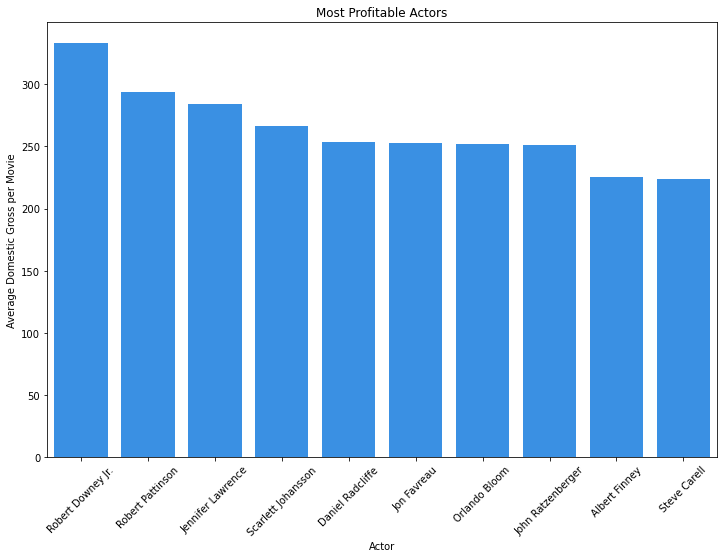

In [55]:
actors_genres_sub.groupby('actor').mean()['gross'].sort_values(ascending=False)
# Sorts actors by the average profitability of the movies that they are in.

x = actors_genres_sub.groupby('actor').mean()['gross'].sort_values(ascending=False).index[0:10]
y = actors_genres_sub.groupby('actor').mean()['gross'].sort_values(ascending=False).values[0:10]

fig, ax = plt.subplots(figsize=[12,8])
ax = sns.barplot(x,y, color='dodgerblue')
ax.set_xlabel('Actor')
ax.set_ylabel('Average Domestic Gross per Movie')
ax.set_title('Most Profitable Actors');
ax.set_xticklabels(labels=x, rotation=45);
plt.savefig('Visualizations/Actor_profitability.png')

Based on the above, it looks like we should target Robert Downey Jr., Robert Pattinson, Jennifer Lawrence, Scarlett Johansson and Daniel Radcliffe if we want a profitable movie!

In [56]:
actors_genres_sub.groupby('actor').mean()['imdb_score'].sort_values(ascending=False)

actor
John Ratzenberger    7.890000
Tom Hanks            7.737500
Albert Finney        7.700000
Orlando Bloom        7.677778
Tom Hardy            7.575000
                       ...   
Frankie Muniz        5.183333
Michael Jai White    5.085714
Udo Kier             4.933333
Alexa PenaVega       4.928571
Taylor Lautner       4.900000
Name: imdb_score, Length: 200, dtype: float64

The above sorts the top 200 actors in the specified genres by the average IMDB score for the movies they are in. None of the names in here appear in the most profitable

# Data Understanding 

In [57]:
df_keywords1 = pd.read_csv('zippedData/movie_metadata.csv')

In [58]:
df_keywords1['plot_keywords'][0]

'avatar|future|marine|native|paraplegic'

The dataset has a column for keywords in the plot (shown above), but similar to genre it has more than one keyword per movie and the keywords are divided by a "|". 

In [59]:
def split_keyword1(keywords):
      return keywords.split('|')[0]

def split_keyword2(keywords):
        if len(keywords.split('|')) > 1:
            return keywords.split('|')[1]
        else:
            return "No second keyword"

def split_keyword3(keywords):
        if len(keywords.split('|')) > 2:
            return keywords.split('|')[2]
        else:
            return "No third keyword"

def split_keyword4(keywords):
        if len(keywords.split('|')) > 3:
            return keywords.split('|')[3]
        else:
            return "No fourth keyword"

def split_keyword5(keywords):
        if len(keywords.split('|')) > 4:
            return keywords.split('|')[4]
        else:
            return "No fifth keyword"

The code above is a little messy but it creates 5 different functions that each return one of the keywords in the column. The function "split_keyword1" returns the first keyword, the function "split_keyword2" returns the second keyword and so on. The if statement within the function exists in case there are titles with only 1 or 2 keywords. If this is the case, without the if statement there would be an error message if we attempted to run 'split_keyword5'. Instead, the function returns the string "No fifth keyword"

In [60]:
df_keywords1.dropna(subset=['plot_keywords'], inplace=True)
df_keywords1['plot_keywords'] = df_keywords1['plot_keywords'].apply(split_keyword1)

In [61]:
df_keywords2 = pd.read_csv('zippedData/movie_metadata.csv')
df_keywords2.dropna(subset=['plot_keywords'], inplace=True)
df_keywords2['plot_keywords'] = df_keywords2['plot_keywords'].apply(split_keyword2)

In [62]:
df_keywords3 = pd.read_csv('zippedData/movie_metadata.csv')
df_keywords3.dropna(subset=['plot_keywords'], inplace=True)
df_keywords3['plot_keywords'] = df_keywords3['plot_keywords'].apply(split_keyword3)

In [63]:
df_keywords4 = pd.read_csv('zippedData/movie_metadata.csv')
df_keywords4.dropna(subset=['plot_keywords'], inplace=True)
df_keywords4['plot_keywords'] = df_keywords4['plot_keywords'].apply(split_keyword4)

In [64]:
df_keywords5 = pd.read_csv('zippedData/movie_metadata.csv')
df_keywords5.dropna(subset=['plot_keywords'], inplace=True)
df_keywords5['plot_keywords'] = df_keywords5['plot_keywords'].apply(split_keyword5)

In [65]:
df_keywords = pd.concat([df_keywords1,df_keywords2, df_keywords3, df_keywords4, df_keywords5])

In [66]:
df_keywords

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,Color,Anthony Vallone,NaN,84.0,2.0,2.0,John Considine,45.0,NaN,Crime|Drama,...,1.0,English,USA,PG-13,3250.0,2005.0,44.0,7.8,NaN,4
5037,Color,Edward Burns,14.0,95.0,0.0,133.0,Caitlin FitzGerald,296.0,4584.0,Comedy|Drama,...,14.0,English,USA,Not Rated,9000.0,2011.0,205.0,6.4,NaN,413
5038,Color,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,NaN,Comedy|Drama,...,6.0,English,Canada,NaN,NaN,2013.0,470.0,7.7,NaN,84
5039,Color,NaN,43.0,43.0,NaN,319.0,Valorie Curry,841.0,NaN,Crime|Drama|Mystery|Thriller,...,359.0,English,USA,TV-14,NaN,NaN,593.0,7.5,16.00,32000


The above is a little repetitive. It creates 5 new dataframes and populated each one with one of the title keywords. dataframe 1 has the first keyword in the 'plot_keyword column', dataframe 2 has the second keyword in the 'plot_keyword' and so on. 

In [67]:
df_keywords = df_keywords[df_keywords['plot_keywords'] != "No second keyword"] 
df_keywords = df_keywords[df_keywords['plot_keywords'] != "No third keyword"] 
df_keywords = df_keywords[df_keywords['plot_keywords'] != "No fourth keyword"] 
df_keywords = df_keywords[df_keywords['plot_keywords'] != "No fifth keyword"] 

# The above eliminates all the instances in which the function didn't have a keyword

# Business Understanding

In [68]:
x= list(df_keywords['plot_keywords'].value_counts().index[0:20])
y= list(df_keywords['plot_keywords'].value_counts().values[0:20])

/Users/kevinmcdonough/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


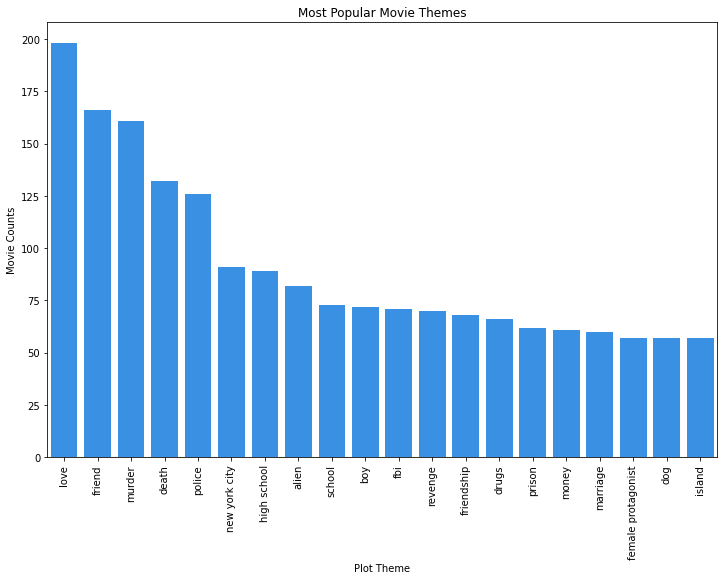

In [69]:
fig, ax = plt.subplots(figsize=[12,8])
ax = sns.barplot(x,y, color='dodgerblue')
ax.set_xlabel('Plot Theme')
ax.set_ylabel('Movie Counts')
ax.set_title('Most Popular Movie Themes');
ax.set_xticklabels(labels=x, rotation=90);
plt.savefig('Visualizations/Keyword_counts.png')

Using our new dataframe of keywords, we created a list of the top 10 words and their associated counts above. The plot word that appears most often is "Love", awwwwwwwww! 

In [70]:
top_100_keywords = list(df_keywords['plot_keywords'].value_counts().index[0:100])

In [71]:
df_keyword_sub = df_keywords[df_keywords['plot_keywords'].isin(top_100_keywords)]
df_keyword_sub = df_keyword_sub.dropna(subset=['gross'])

The above creates a list of 100 keywords that appear most frequently in the dataset and then filters out all movies that don't contain a keyword in this list and also filters out entries that don't have a value in the 'gross column'

In [72]:
df_keyword_sub['gross'] = df_keyword_sub['gross'].apply(lambda x: x/1000000)
df_keyword_sub.groupby('plot_keywords').mean()['gross'].sort_values(ascending=False)

plot_keywords
superhero                   136.025491
princess                    118.124350
magic                       111.002026
battle                      101.337732
monster                      97.822698
                               ...    
gay                          20.367470
female frontal nudity        19.785387
box office flop              18.272964
title directed by female     16.599813
sex                          16.067441
Name: gross, Length: 100, dtype: float64

In [73]:
x = df_keyword_sub.groupby('plot_keywords').mean()['gross'].sort_values(ascending=False).index[0:20]
y = df_keyword_sub.groupby('plot_keywords').mean()['gross'].sort_values(ascending=False).values[0:20]

/Users/kevinmcdonough/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


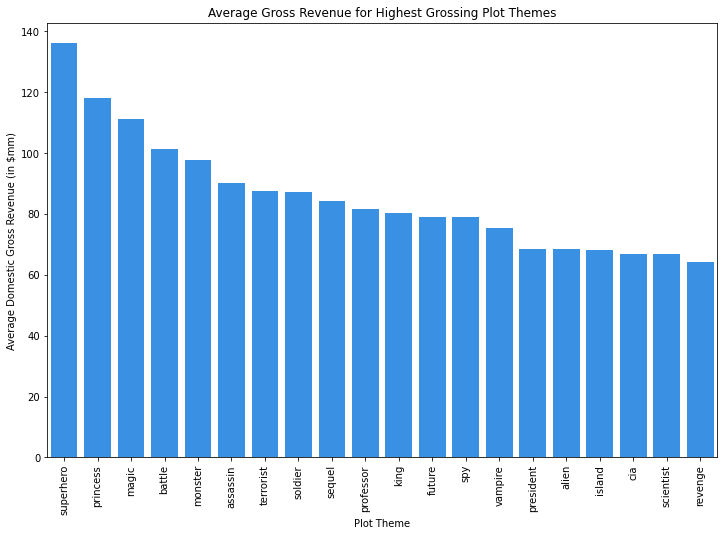

In [74]:
fig, ax = plt.subplots(figsize=[12,8])
ax = sns.barplot(x,y,color='dodgerblue')
ax.set_xlabel('Plot Theme')
ax.set_ylabel('Average Domestic Gross Revenue (in $mm)')
ax.set_title('Average Gross Revenue for Highest Grossing Plot Themes');
ax.set_xticklabels(labels=x, rotation=90); 
plt.savefig('Visualizations/Keyword_revenue.png')

Above, we grouped movies by keywords (aka plot themes) and then calculated the average revenue of movies containing that theme. The top 10 themes associated with the highest revenue are listed above. Due to this output, we would recommend creating a movie that has one of these themes

In this section we identified 5 genres that generally translate to higher profitability: Family, Action, Adventure, Animation, Musical. We then created a subset of the data featuring movies from these categories and identified the actors and directors that have been involved in the highest earning films. We also identified plot themes that appear in movies that are the most successful in the box office. 

<b>Genres to target:</b> Family, Action, Adventure, Animation, Musical

<b>Directors to target:</b> Joss Whedon, George Lucas, Christopher Nolan, Andrew Adamson, Peter Jackson 

<b>Actors to target:</b> Robert Downey, Robert Pattinson, Jennifer Lawrence, Kevin Dunn, Scarlett Johansson, Daniel Radcliffe, Jon Favreau, Orlando Bloom, John Ratzenberger, Albert Finney

<b>Plot Themes:</b> superhero, princess, magic, battle, monster, assasin, terrorist, soldier, professor, king, future, spy, vampire, president, alien, island, CIA, scientist, revenge

## The Numbers Data

In [75]:
df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


## Data Cleaning

Luckily, we have no missing values. However, we need the data columns for production_budget, domestic_gross, and worldwide_gross to be integers, rather than strings, in order to properly analyze them. 

In [77]:
#cleaning the production budget column, domestic_gross column, worldwide_gross column to be floats
df['prod_budg_fixed'] = df['production_budget'].str.replace('$', '').str.replace(',','').astype(float)
df['dom_gross_fixed'] = df['domestic_gross'].str.replace('$', '').str.replace(',','').astype(float)
df['world_gross_fixed'] = df['worldwide_gross'].str.replace('$', '').str.replace(',','').astype(float)

In [78]:
df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,prod_budg_fixed,dom_gross_fixed,world_gross_fixed
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",425000000.0,760507625.0,2.776345e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",410600000.0,241063875.0,1.045664e+09
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",350000000.0,42762350.0,1.497624e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",330600000.0,459005868.0,1.403014e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",317000000.0,620181382.0,1.316722e+09


In [79]:
df.describe()

,id,prod_budg_fixed,dom_gross_fixed,world_gross_fixed
count,5782.000000,5.782000e+03,5.782000e+03,5.782000e+03
mean,50.372363,3.158776e+07,4.187333e+07,9.148746e+07
std,28.821076,4.181208e+07,6.824060e+07,1.747200e+08
min,1.000000,1.100000e+03,0.000000e+00,0.000000e+00
25%,25.000000,5.000000e+06,1.429534e+06,4.125415e+06
50%,50.000000,1.700000e+07,1.722594e+07,2.798445e+07
75%,75.000000,4.000000e+07,5.234866e+07,9.764584e+07
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09


## Data Analysis
With the cleaning out of the way, we have a column of floats for production budget called prod_budg_fixed, a column of floats for domestic gross called dom_gross_fixed, and a column of floats for worldwide gross called world_gross_fixed. We can now start exploring relationships between production budget and the gross revenue

In [80]:
#Checking the Pearson Correlation Coefficient
df.corr(method='pearson')

,id,prod_budg_fixed,dom_gross_fixed,world_gross_fixed
id,1.000000,-0.035278,0.008255,-0.009422
prod_budg_fixed,-0.035278,1.000000,0.685682,0.748306
dom_gross_fixed,0.008255,0.685682,1.000000,0.938853
world_gross_fixed,-0.009422,0.748306,0.938853,1.000000


From here, we can see that there is a relatively high correlation between production budget and worldwide gross (0.748306), and an extremely high correlation between the domestic gross and worldwide gross, indicating that a movie doing well in domestic theaters will also do well internationally. Logical, but nice to know.

y=3.126943x+(-7285667.054592)
y2=1.119087x+(6523888.576660)


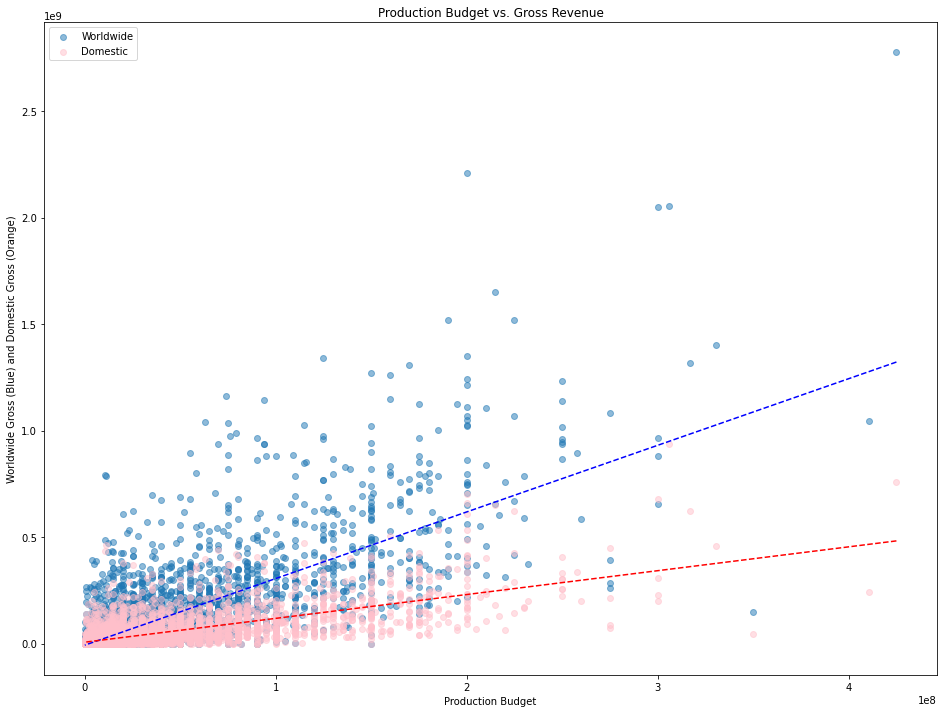

In [81]:
#scatterplot of production budget vs worldwide gross
import matplotlib.pyplot as plt
from matplotlib.axis import Axis
import seaborn as sns
import numpy as np
import pylab as plb


#code for basic scatter plot
x = df['prod_budg_fixed']
y = df['world_gross_fixed']

fig, ax = plt.subplots(figsize=(16, 12))

#going for more of a 'heatmap' style plot for readability, so opacity is low
ax.scatter(x, y, alpha=0.5)
ax.set_title('Production Budget vs. Gross Revenue')
ax.set_xlabel('Production Budget')
ax.set_ylabel('Worldwide Gross (Blue) and Domestic Gross (Orange)')

#domestic gross scatter plot
y2 = df['dom_gross_fixed']
ax.scatter(x, y2, alpha=0.5, c='pink')
plt.legend(['Worldwide', 'Domestic'])

#finding the trend line
z = np.polyfit(x,y,1)
p = np.poly1d(z)
plb.plot(x, p(x), 'b--')
#Supposedly the equation for the line (need to look into this more to understand it)
print("y=%.6fx+(%.6f)"%(z[0],z[1]))

#second trend line
z2 = np.polyfit(x,y2,1)
p2 = np.poly1d(z2)
plb.plot(x, p2(x), 'r--')
print("y2=%.6fx+(%.6f)"%(z2[0],z2[1]))